# 0.0 Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re
import warnings

from sklearn import ensemble as en
from sklearn import cluster as c
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc 
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score
from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from pandas_profiling import ProfileReport

from plotly import express as px

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 0.1 Helper Function

In [2]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def hyperparameter_tunning(model, clusters,data):
    # wss
    wss = kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
    wss.fit(data)
    # ss 
    ss = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
    ss.fit(data)
    df = pd.DataFrame({'Metric': ['WSS','SS'], 'Score':[wss.elbow_score_.round(2),ss.elbow_score_.round(2)],
                       'Recomended k':[wss.elbow_value_,ss.elbow_value_]})
    return df
   

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df = pd.read_csv('../data/raw/Ecommerce.csv',encoding= 'unicode_escape')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [4]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente resid

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [6]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [7]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NAs

In [9]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

## 1.5 Replace NAs

In [10]:
# Separate dataframe with NAs
df_missing = df1.loc[df1.customer_id.isna()]
df_full = df1.loc[~df1.customer_id.isna()]

In [11]:
# Checking if any invoice_no in df_missing is present in df_full so we could add the respective customer_id
df_full.invoice_no.isin(df_missing.invoice_no.drop_duplicates()).sum()

0

In [12]:
df_missing.invoice_no.nunique()

3710

In [13]:
# create customer_ids in a reference dataframe
df_invoice = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_invoice['customer_id'] = np.arange(19000,19000+len(df_invoice),1)

# merge original dataframe with reference dataframe
df1 = pd.merge(df1,df_invoice, on='invoice_no',how='left')

# coalesce - fill the customer_id column with the column that doen not have NA.
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x','customer_id_y'], axis=1,inplace=True)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


## 1.6 Change data types

In [14]:
# invoice date
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7 Descriptive Statistics

In [16]:
num = df1.select_dtypes(include=['int64','float64'])
cat = df1.select_dtypes(exclude=['int64','float64'])

### 1.7.1 Numerical Variables

In [17]:
# Central Tendency - Mean, Median

ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersion - Min, Max, Standard Deviation, Range, Skew, Kurtosis

d1 = pd.DataFrame(num.apply(np.std)).T
d2 = pd.DataFrame(num.apply(np.min)).T
d3 = pd.DataFrame(num.apply(np.max)).T
d4 = pd.DataFrame(num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

# Concatanate
num_df = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
num_df.columns =['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_df

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,quantity,9.552250,3.00,218.080957,-80995.00,80995.0,161990.00,-0.264076,119769.160031
1,unit_price,4.611114,2.08,96.759764,-11062.06,38970.0,50032.06,186.506972,59005.719097


### Notes

1. `quantity` negativo pode ser devolução
2. `unit_price` negativo.

### 1.7.2 Categorical variables

Invoice Nº

In [18]:
# Identifying all invoice numbers that represent chargebacks
df_chargeback = df1.loc[df1.invoice_no.apply(lambda x: bool(re.search('[^0-9]+',x))),:]

# # Checking if the all chargebacks have negative quantity (greater than zero)
# df_chargeback[df_chargeback.quantity>0]['quantity'].any()

In [19]:
print('Total number of chargebacks:',df_chargeback.shape[0])
print('Percetage of chargebacks:', round((df_chargeback.shape[0]/df1.shape[0]),3))
print('Total number or negative quantity: {}'.format(len(df_chargeback[df_chargeback.quantity<0])))

Total number of chargebacks: 9291
Percetage of chargebacks: 0.017
Total number or negative quantity: 9288


Stock Code

In [20]:
# Identifying stock codes that contain only characters

df1.loc[df1.stock_code.apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

**To Do**: remove stock_code that contain ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']

Description

In [21]:
df1.description.head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

**To Do**: remove `description`

Country

In [22]:
df1.country.value_counts(normalize=True).head().round(2)

United Kingdom    0.91
Germany           0.02
France            0.02
EIRE              0.02
Spain             0.00
Name: country, dtype: float64

In [23]:
# Top 10 countries with the most purchases
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


**To Do**: Keep only country names (Remove 'European Community', 'Unspecified')

# 2.0 Feature Filtering

In [24]:
df2 = df1.copy()

## 2.1 Numerical features

In [25]:
# Unit price - Select product with at least 0.04 unit price 
df2 = df2.loc[df2['unit_price']>=0.04]

# Quantity - Remove customers with zero quantity in total
total_quantity = df2[['quantity','customer_id']].groupby('customer_id').sum()
customers_zero_quantity = total_quantity[total_quantity.quantity==0].index.to_list()

df2 = df2.loc[~df2['customer_id'].isin(customers_zero_quantity)]

## 2.2 Categorical features

In [26]:
# Stock Code - remove stock_code that contain ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 =df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Description - remove description
df2.drop('description', axis=1, inplace=True)

# Country - Keep only country names: (Remove 'European Community', 'Unspecified')
df2 =df2[~df2.country.isin(['European Community', 'Unspecified'])]

# Bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]



## 2.3 Separate dataset

In [27]:
# Quantity - CREATE TWO SEPARATE DATAFRAMES
# 1 for the purchases and another for the returns

df_chargeback = df2.loc[df2['quantity']<0,:]
df_purchases= df2.loc[df2['quantity']>0,:]

# 3.0 Feature Engeneering

In [28]:
df3 = df2.copy()

## 3.1 Feature Creation

In [29]:
### Feature Ideias
# Moving average - 7d, 15d, 30d
# Quantidade de compras antes do dia 15 e depois do dia 15 por mês

The main ideia here is to reduce the data granularity into rows that represent each one a different customer.

In [30]:
# Data reference
df_ref = df2[['customer_id']].drop_duplicates().reset_index()
df_ref.drop('index',axis=1, inplace=True)

### 3.1.1 Gross Revenue

In [31]:
# Gross Revenue per item purchased
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

# Gross Revenue per customer
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref  =pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency (Days since the last purchase)

In [32]:
# Recency - Last Day purchase
df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3  Number of purchases

In [33]:
df_number_purch = df_purchases[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref,df_number_purch, on='customer_id', how='left' )

df_ref.rename(columns={'invoice_no':'number_of_purchases'}, inplace=True)
# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
dtype: int64

### 3.1.4 Quantity of products purchased

In [34]:
df_bs =df_purchases[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_bs.rename(columns={'quantity':'total_quantity'}, inplace=True)
df_ref = pd.merge(df_ref, df_bs, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
total_quantity         91
dtype: int64

### 3.1.5 Product variety (Unique products purchased)

In [35]:
df_var = df_purchases[['customer_id','stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_var, on='customer_id',how='left')
df_ref.rename(columns={'stock_code':'product_variety'}, inplace=True)

# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
total_quantity         91
product_variety        91
dtype: int64

### 3.1.6 Average Ticket

In [36]:
df_avg_ticket = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
number_of_purchases    91
total_quantity         91
product_variety        91
avg_ticket             91
dtype: int64

### 3.1.7 Average Recency Days 

In [37]:
# Create columns to make the calculation
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'],ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] =df_aux['invoice_date'].shift() #next invoice date

# Calculate recency between invoices
df_aux['avg_recency_days'] = df_aux.apply(lambda x:(x['invoice_date']-x['previous_date']).days if x['customer_id']== x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop(['invoice_date','next_customer_id','previous_date'],axis=1).dropna()

# Calculate average recency in days
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# Merge
df_ref = pd.merge(df_ref,df_avg_recency_days,on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
dtype: int64

### 3.1.8 Devoluções

In [38]:
df_return = df_chargeback[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_return.rename(columns={'quantity':'returns'}, inplace=True) # rename column
df_ref = pd.merge(df_ref,df_return, on='customer_id', how='left')
df_ref['returns'] = df_ref['returns'] * -1
df_ref['returns'].fillna(value=0, inplace=True) # Fill NAs with O (clients with no chargebacks)

df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
dtype: int64

### 3.1.9 Frequency

In [39]:
df_aux = ( df2[['customer_id', 'invoice_no','invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date','max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days)+1 ),
                                                                purchases = ('invoice_no','count') )).reset_index()  
# Frequency

df_aux['frequency'] = df_aux[['purchases','days_']].apply(lambda x: x['purchases']/x['days_'] if x['days_'] != 0 else 0, axis=1)
 
# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
frequency                 0
dtype: int64

### 3.1.10 Average Basket Size (Média de produtos comprados por compra)

In [40]:
df_aux = ( df_purchases[['customer_id','invoice_no','quantity']].groupby('customer_id').agg(n_purchases=('invoice_no','nunique'),
                                                                                         n_products=('quantity','sum')).
                                                                                        reset_index())

# Calculate Average Basket Size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
frequency                 0
avg_basket_size          91
dtype: int64

### 3.1.11 Unique Basket Size (Média de produtos únicos comprados por compra)

In [41]:
df_aux = ( df_purchases[['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(n_purchases=('invoice_no','nunique'),
                                                                                         unq_products=('stock_code','count')).
                                                                                        reset_index())

# Calculate Average Basket Size
df_aux['unq_basket_size'] = df_aux['unq_products'] / df_aux['n_purchases']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','unq_basket_size']], on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id               0
gross_revenue            91
recency_days             91
number_of_purchases      91
total_quantity           91
product_variety          91
avg_ticket               91
avg_recency_days       2813
returns                   0
frequency                 0
avg_basket_size          91
unq_basket_size          91
dtype: int64

# 4.0 Exploratory Data Analysis

In [42]:
# Drop NAs
df_ref.dropna(inplace=True)

df4 = df_ref.copy()

In [43]:
# # Using Pandas Profile
# profile = ProfileReport(df4, title='Insiders Clustering - Exploratory Data Analysis', html={'style':{'full_width':True}})
# profile.to_file(output_file="EDA1.html")

## 4.1 Univariate Analysis

Notes from Pandas Profilling analysis:

* Possibility of outlier in `gross_revenue` (big difference between 95-th percentile and Maximum)
* Half of the customer base has done a purchase in the last month (`recency_days` median = 31 days)
* 75% of the customers have done only up to 6 purchases.
* Possibility of outlier: Interesting `total_quantity` mean (~ 1613)
* 95% of the customers have up to 90 dollars in `avg_ticket`
* Almost half of the customers has done a `return` (49,9%)
* Half of the customers has bought, in average,up to 172 products per purchase (`avg_basket_size`).

## 4.2 Bivariate Analysis

Features Notes:
* `avg_ticket` and `frequency` do not present a significant variance
* `recency_days` and `avg_recency_days` carry the same information content.
* `avg_basket_size` is more important than `unq_basket_size` in terms of relevent information to the problem.

<Figure size 1800x864 with 0 Axes>

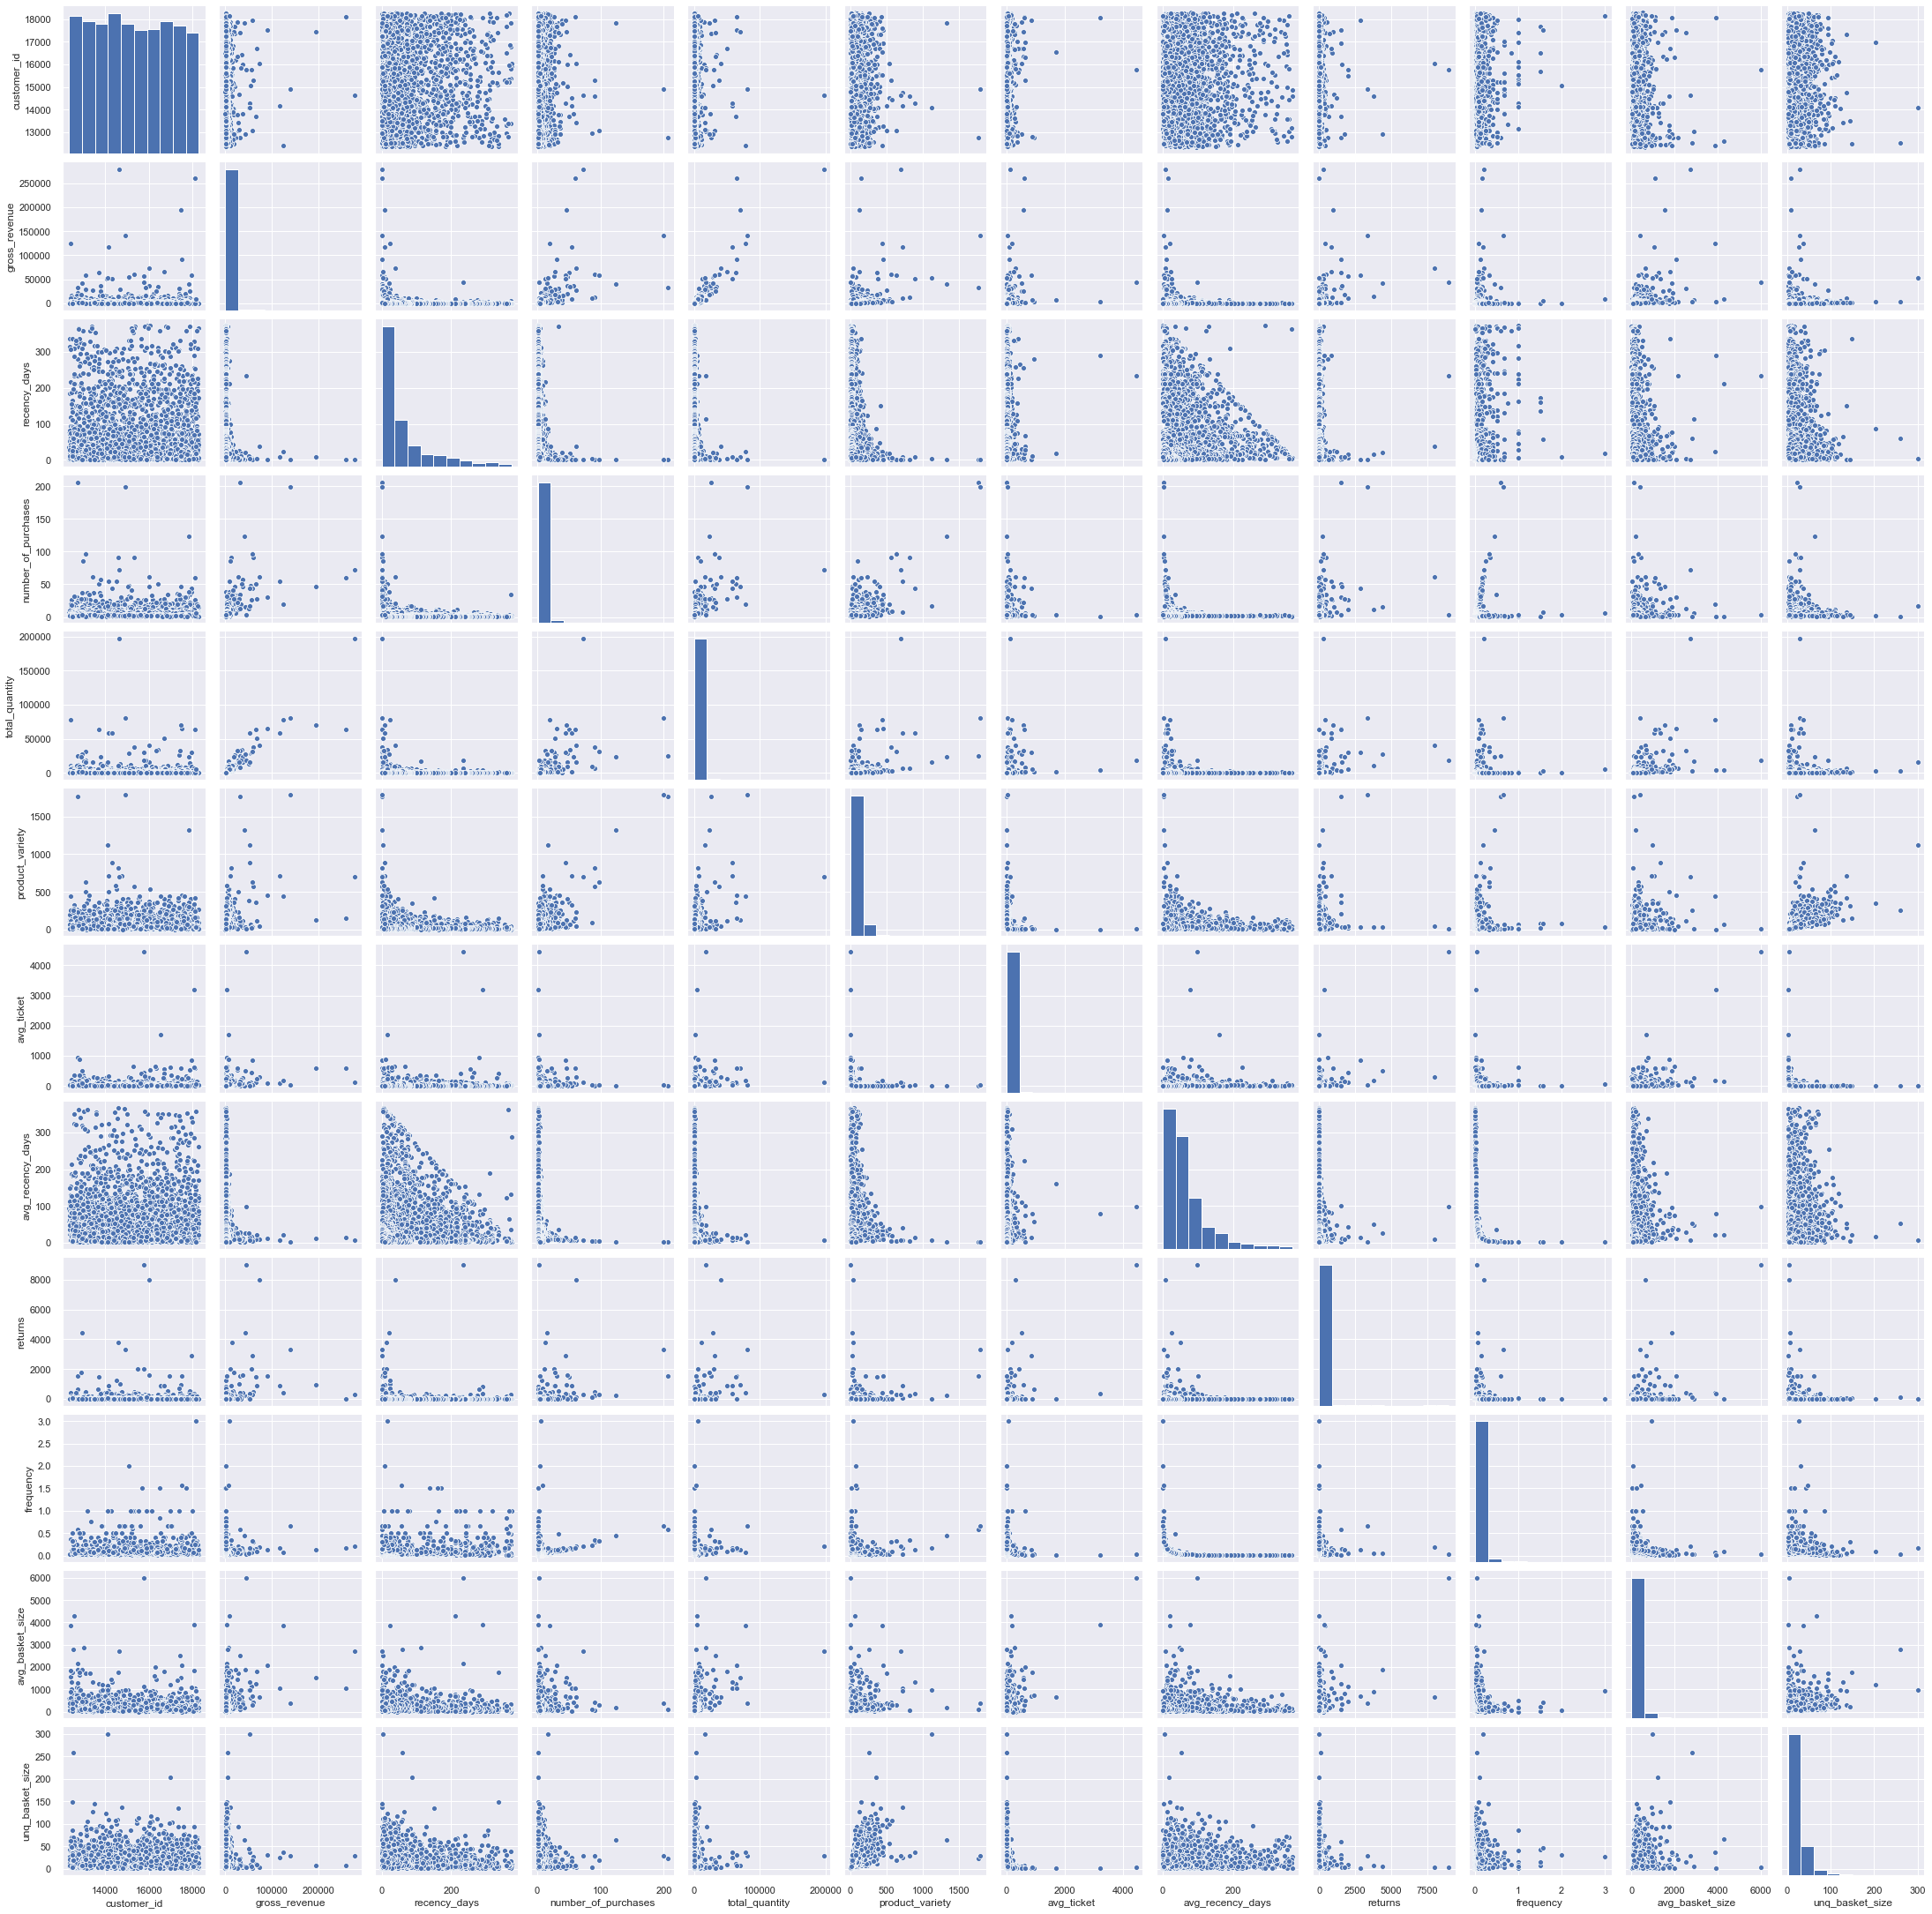

In [44]:
plt.figure(figsize(25,12));
# sns.pairplot( df4[['gross_revenue','recency_days', 'number_of_purchases','total_quantity', 'product_variety',
#                   'returns','avg_basket_size']]);

sns.pairplot( df4);

## 4.3 Data Space Study

In [45]:
df_space = df4.copy()

In [46]:
# MinMaxScaler definition
mms = pp.MinMaxScaler()

# Standardization 
df_space['gross_revenue'] = mms.fit_transform( df_space[['gross_revenue']])
df_space['recency_days'] = mms.fit_transform( df_space[['recency_days']])
df_space['number_of_purchases'] = mms.fit_transform( df_space[['number_of_purchases']])
df_space['total_quantity'] = mms.fit_transform( df_space[['total_quantity']])
df_space['product_variety'] = mms.fit_transform( df_space[['product_variety']])
df_space['avg_ticket'] = mms.fit_transform( df_space[['avg_ticket']])
df_space['avg_recency_days'] = mms.fit_transform( df_space[['avg_recency_days']])
df_space['returns'] = mms.fit_transform( df_space[['returns']])
df_space['frequency'] = mms.fit_transform( df_space[['frequency']])
df_space['avg_basket_size'] = mms.fit_transform( df_space[['avg_basket_size']])
df_space['unq_basket_size'] = mms.fit_transform( df_space[['unq_basket_size']] )


X_space = df_space.drop('customer_id',axis=1)

### 4.3.1 PCA

**Note**: before que introduction of `unq_basket_size`, only one component had almost 99& variance of the dataset

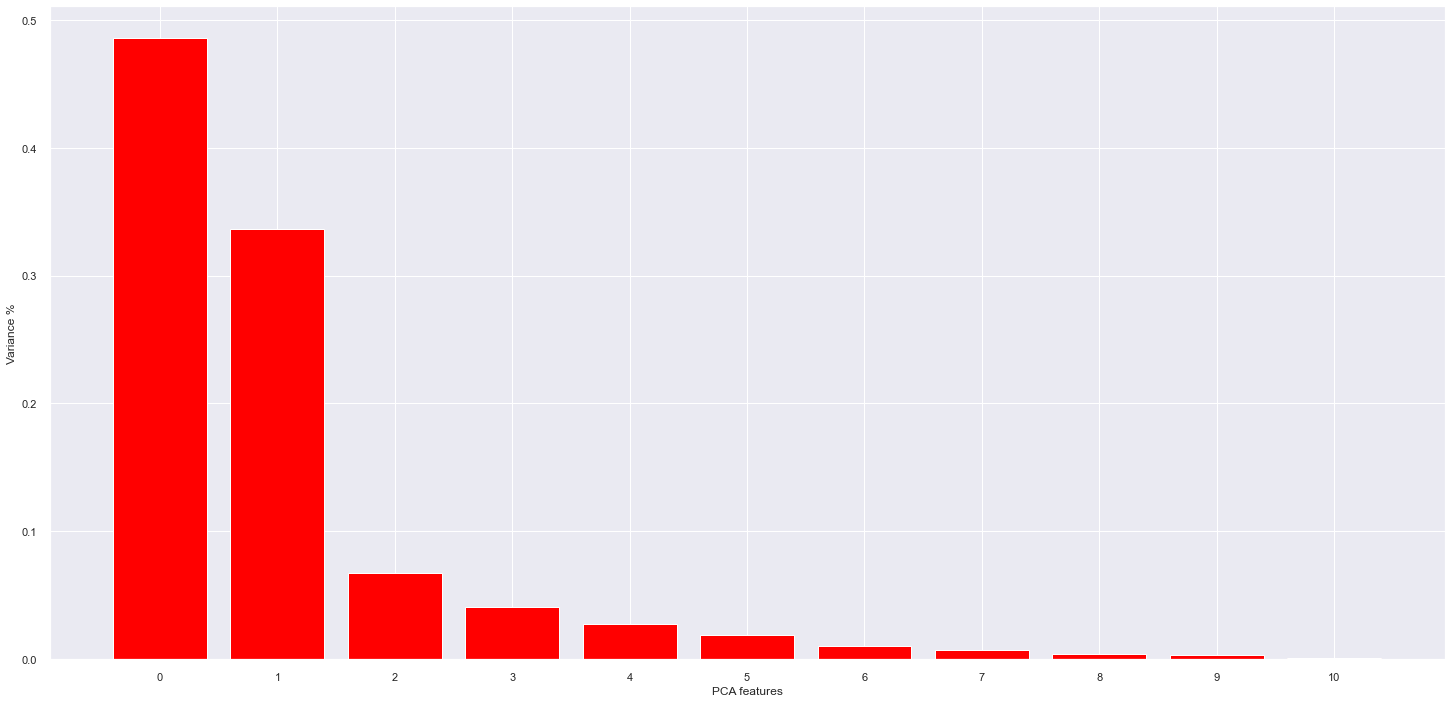

In [47]:
# Create PCA
pca = PCA(n_components = X_space.shape[1])
principal_components = pca.fit_transform(X_space)
                                        
# Plot the explained variance
features  = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)

# SAve components to a Dataframe
df_pca = pd.DataFrame(principal_components)

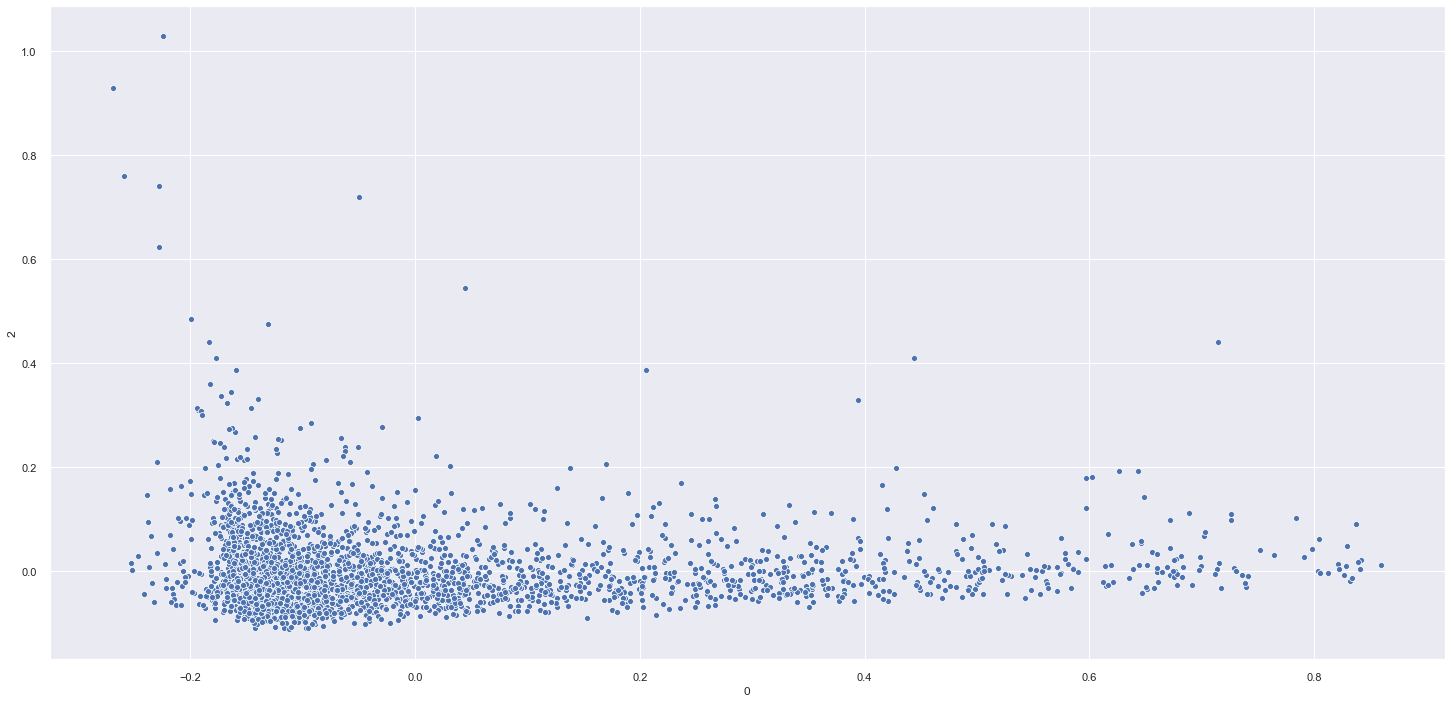

In [48]:
sns.scatterplot(x=0,y=2,data=df_pca);

### 4.3.2 UMAP

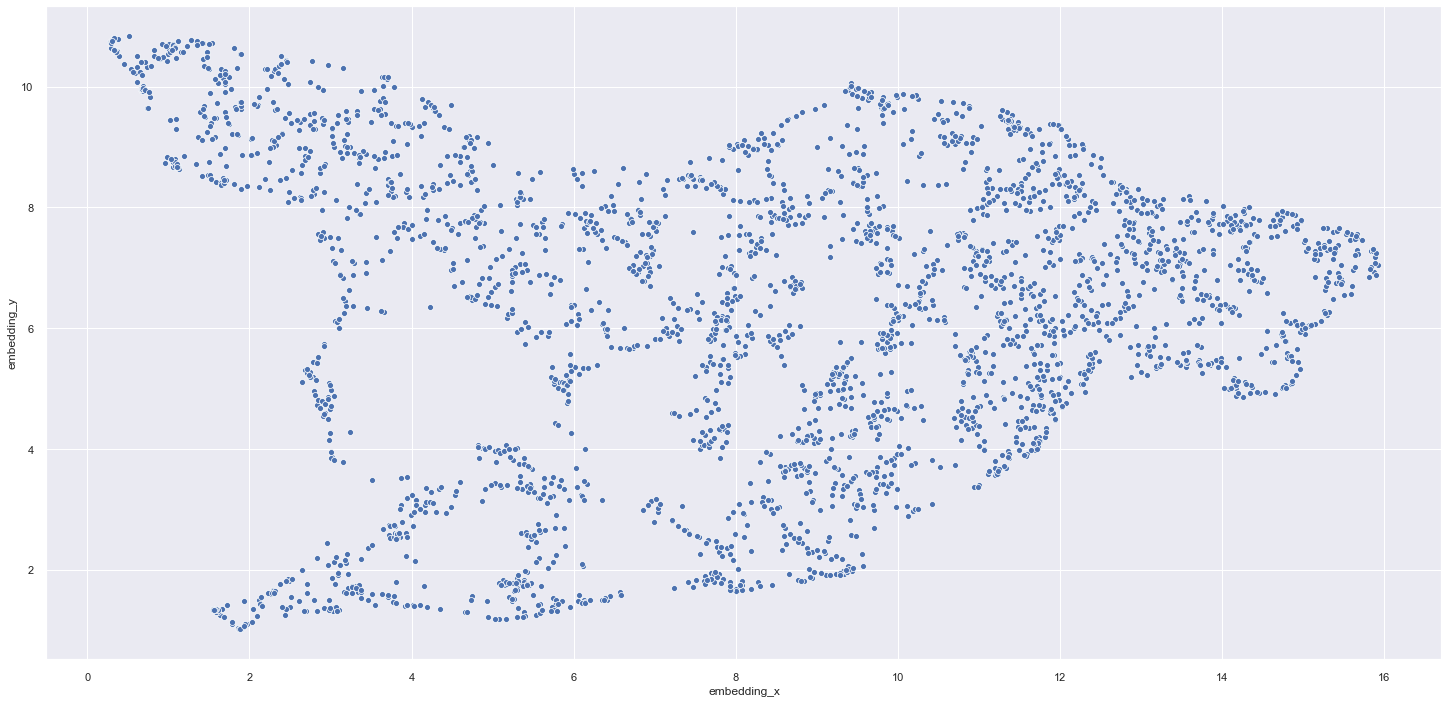

In [49]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_space)

# embedding

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x ='embedding_x',
                y = 'embedding_y',
               data=df_pca);

###  4.3.3. t-SNE

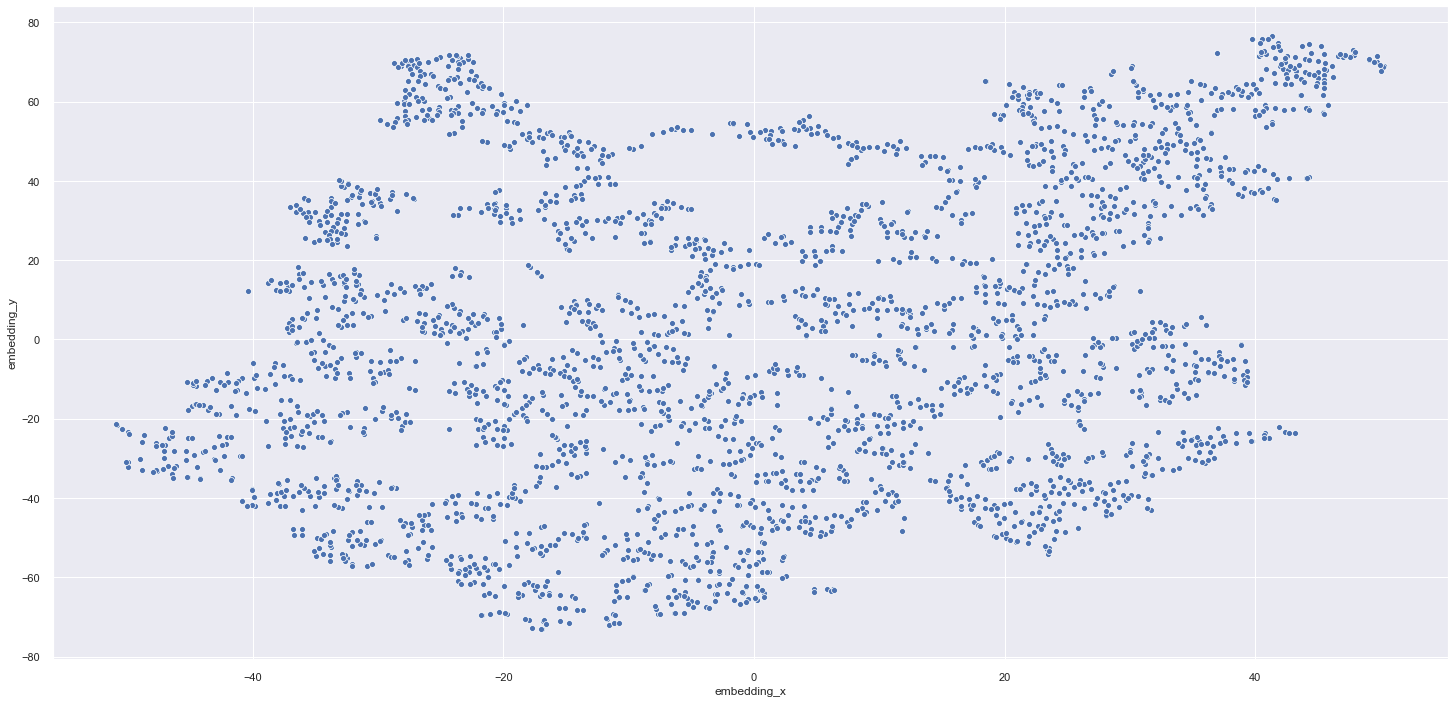

In [50]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X_space)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca );

### 4.3.4 Tree-Based Embedding

**Note**: the dataframe below shows a unique customer per row, a unique tree per column. The values inside each cell represents the position (leaf number) of the respective customer in that tree.

In [51]:
# training dataset
X = df4.drop(columns=['customer_id','gross_revenue'],axis=1)
y =df4['gross_revenue']

# model definition
rf = en.RandomForestRegressor( n_estimators=100, random_state=42)

# model training
rf.fit(X,y)

# Turn leafs into dataframe
df_leaf = pd.DataFrame(rf.apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3177,3025,3250,2873,2881,3292,3120,3156,3395,3332,2838,3286,3142,3149,2771,3189,3127,2839,2800,3035,3191,3205,3170,3312,2906,3092,3257,2940,3074,3230,3094,3333,2857,3151,3160,3173,3411,3000,3242,3191,2995,3160,3397,3288,3176,3314,2747,3287,3154,3120,3146,3153,3084,3135,2985,3258,3342,3357,3101,3301,2986,3309,3195,3183,3073,2984,3211,3298,3017,3232,3271,3308,3089,2949,3084,3367,3331,3004,3193,3080,3203,3311,3144,2844,3265,3342,3273,3231,3123,2903,2973,3110,3048,3098,3140,3360,3028,3299,3021,2880
1,2965,3049,2827,2793,2748,3076,2785,2802,2938,2888,2776,2593,3074,3097,2715,3146,2784,2814,2548,2882,3051,2849,2808,2729,3066,2803,2880,2908,2542,3057,2727,3236,3073,2991,3083,2555,2826,2945,2710,2777,2947,2745,2825,2781,3093,2896,2741,2943,2950,3089,3133,3087,2686,3006,2738,2916,2839,2934,2982,2847,3058,2543,2793,3003,3084,3041,2971,2919,3013,2867,2893,2927,3017,2891,3113,2885,2823,2991,2907,3147,2658,2874,2887,2703,2842,3138,2700,3143,3127,2701,2884,2870,3008,3055,3106,2957,2961,2860,3051,2832
2,3525,3447,3601,3610,3562,3590,3590,3615,3678,3580,3564,3462,3546,3652,3529,3521,3596,3594,3497,3478,3625,3552,3637,3474,3501,3541,3499,3594,3574,3737,3558,3692,3610,3637,3580,3427,3670,3562,3525,3369,3609,3459,3660,3601,3570,3620,3476,3630,3657,3598,3634,3658,3587,3633,3630,3603,3605,3669,3564,3560,3584,3587,3569,3679,3464,3608,3631,3537,3613,3581,3558,3665,3564,3545,3633,3545,3558,3592,3518,3590,3530,3596,3599,3480,3498,3631,3574,3709,3546,3506,3585,3469,3461,3577,3598,3545,3580,3621,3544,3620
3,1666,1497,1549,2195,1835,1595,2116,2193,1369,1554,1478,1504,1342,1586,1813,1803,1885,1874,1295,1479,1947,1198,1363,1560,1525,2144,1218,1828,1872,1553,1793,1584,1286,1778,1493,1529,2225,2075,1430,1576,1639,1468,1520,2263,1759,2007,1692,1464,1417,1486,2061,1272,1574,1486,2139,1571,1524,1490,1230,2015,1567,1311,2033,1451,1998,1544,1586,1745,1530,1925,1391,1525,1819,2344,1225,2081,1511,1463,1922,1948,1818,1206,1578,1445,1173,1830,1535,2089,1219,1535,1847,1208,1846,1957,2051,2083,1517,2173,2062,2107
4,175,567,193,703,682,720,745,686,593,185,907,322,718,715,189,600,165,716,792,725,584,890,730,230,609,170,173,645,196,926,183,882,165,464,564,583,183,211,581,522,710,680,924,611,596,197,169,742,726,566,609,728,645,480,568,914,233,209,647,574,741,713,688,594,615,765,186,624,583,694,678,154,611,585,691,609,721,433,666,186,209,191,186,213,612,652,223,217,87,199,220,172,586,718,673,146,904,574,598,197


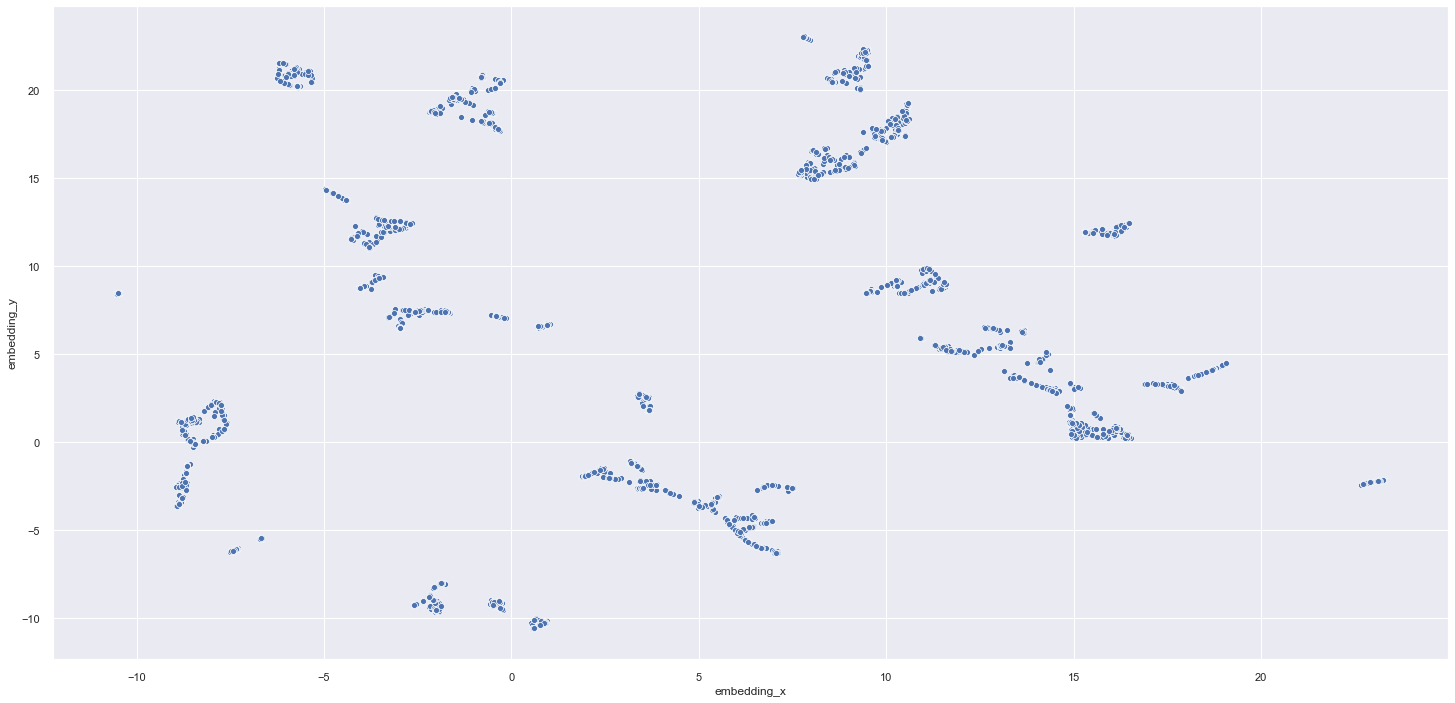

In [52]:
# Reduce dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca );

# 5.0 Data Preparation

In [53]:
df5 = df4.copy()

 Standard Scaler

In [54]:
ss = pp.StandardScaler()

df5.gross_revenue = ss.fit_transform(df5[['gross_revenue']])
df5.recency_days = ss.fit_transform(df5[['recency_days']])
df5.number_of_purchases = ss.fit_transform(df5[['number_of_purchases']])
df5.total_quantity = ss.fit_transform(df5[['total_quantity']])
df5.avg_basket_size = ss.fit_transform(df5[['avg_basket_size']])
df5.product_variety = ss.fit_transform(df5[['product_variety']])
df5.avg_ticket = ss.fit_transform(df5[['avg_ticket']])
df5.avg_recency_days = ss.fit_transform(df5[['avg_recency_days']])
df5.returns = ss.fit_transform(df5[['returns']])
df5.frequency = ss.fit_transform(df5[['frequency']])
df5.avg_basket_size = ss.fit_transform(df5[['avg_basket_size']])
df5.unq_basket_size = ss.fit_transform(df5[['unq_basket_size']])

In [55]:
# Check data preparation
df5.head()

,customer_id,gross_revenue,recency_days,number_of_purchases,total_quantity,product_variety,avg_ticket,avg_recency_days,returns,frequency,avg_basket_size,unq_basket_size
0,17850,0.265138,3.956354,3.187053,0.025745,-0.604136,-0.122941,-0.502907,0.022525,3.192346,-0.652382,-0.690335
1,13047,0.052468,-0.105919,0.367647,-0.034288,0.262485,-0.116649,-0.632800,0.004763,-0.102800,-0.286967,-0.163154
2,12583,0.394612,-0.800105,1.044305,0.602447,0.355337,-0.032970,-0.696763,0.058050,-0.126019,0.351366,-0.344621
3,13748,-0.172589,0.395437,-0.083457,-0.200735,-0.573185,0.008571,0.397163,-0.119572,-0.335316,-0.522320,-0.851359
4,15100,-0.179707,3.454997,-0.309010,-0.263568,-0.810474,2.168938,-0.926438,-0.041419,0.557111,-0.738211,-1.087609


# 6.0 Feature Selection

In [56]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

This step servers for testing how many clusters fits the model the best.

In [57]:
X = df6.drop('customer_id',axis=1)

# Listing possible values for k
clusters =[2,3,4,5,6,7]

## 7.1 KMeans

In [58]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # Model training
    kmeans_model.fit(X)

    # Model Prediction
    labels = kmeans_model.predict(X)

    # Model performance
    sil_score = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil_score)

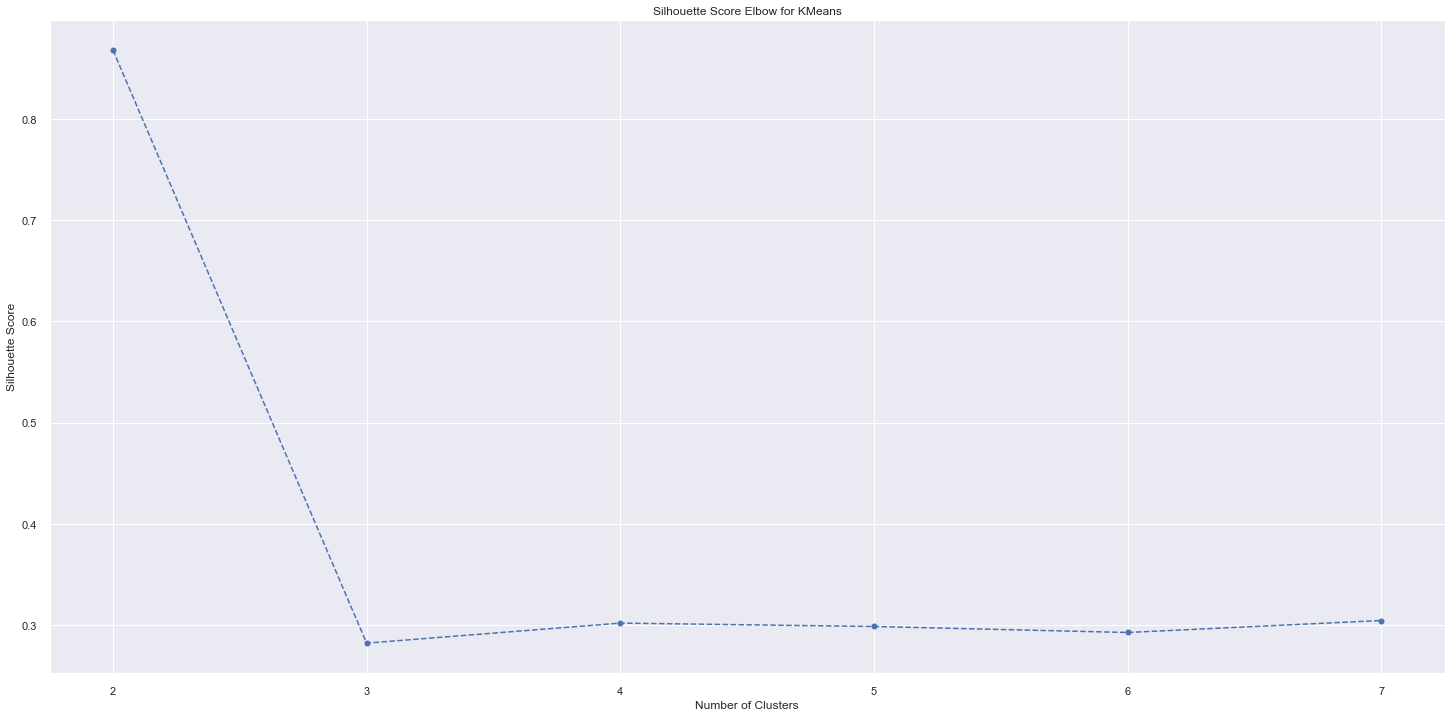

In [59]:
# Plot Silhouette Score Elbow
plt.plot(clusters, kmeans_list, linestyle='--', marker='o',color='b');
plt.title('Silhouette Score Elbow for KMeans')
plt.ylabel('Silhouette Score');
plt.xlabel('Number of Clusters');

## 7.2 GMM

In [60]:
gmm_list = []
for k in clusters:
    # Model Definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # Model Training
    gmm_model.fit(X)

    # Model Prediction
    labels = gmm_model.predict(X)

    # Model Performance
    sil_score = m.silhouette_score(X ,labels, metric='euclidean')
    gmm_list.append(sil_score)

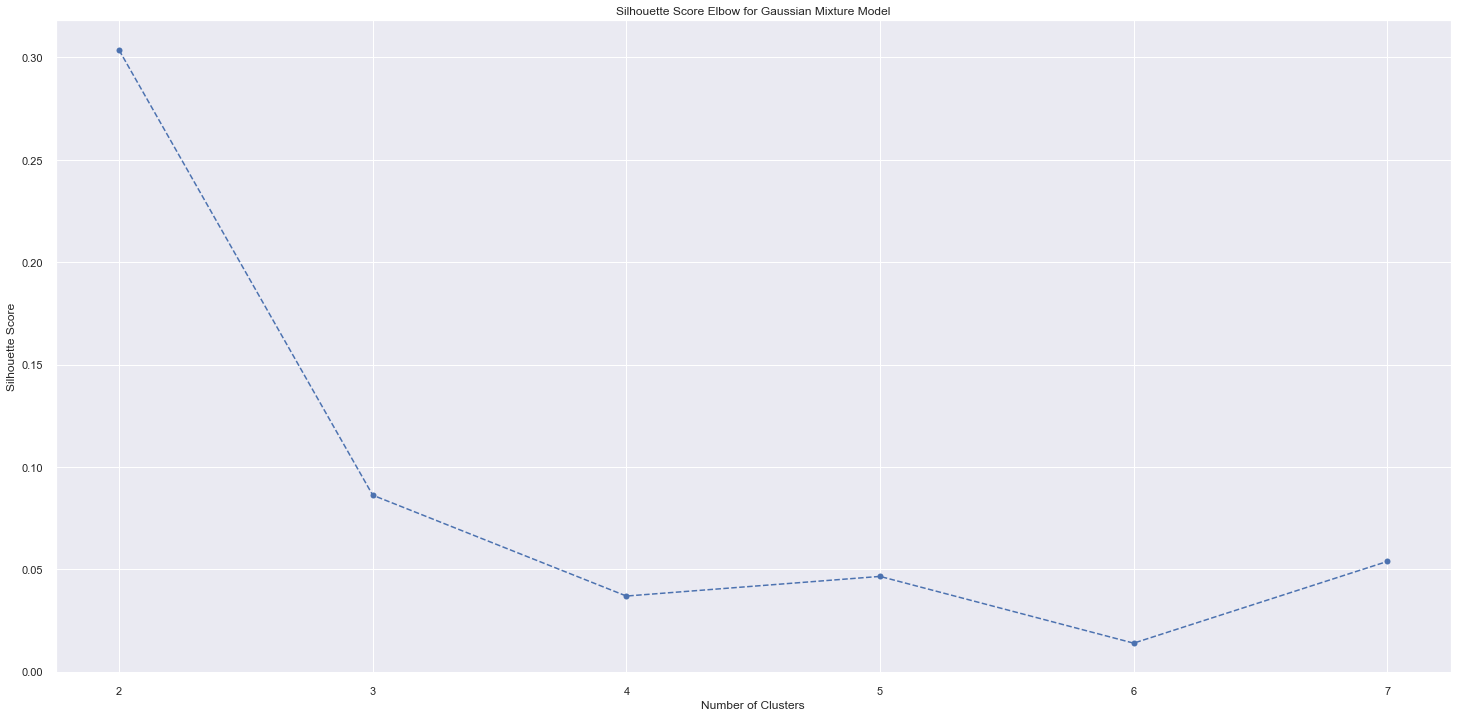

In [61]:
# Plot Silhouette Score Elbow
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.title('Silhouette Score Elbow for Gaussian Mixture Model');
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');

## 7.3 Hierarchical Clustering

In [68]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

[]

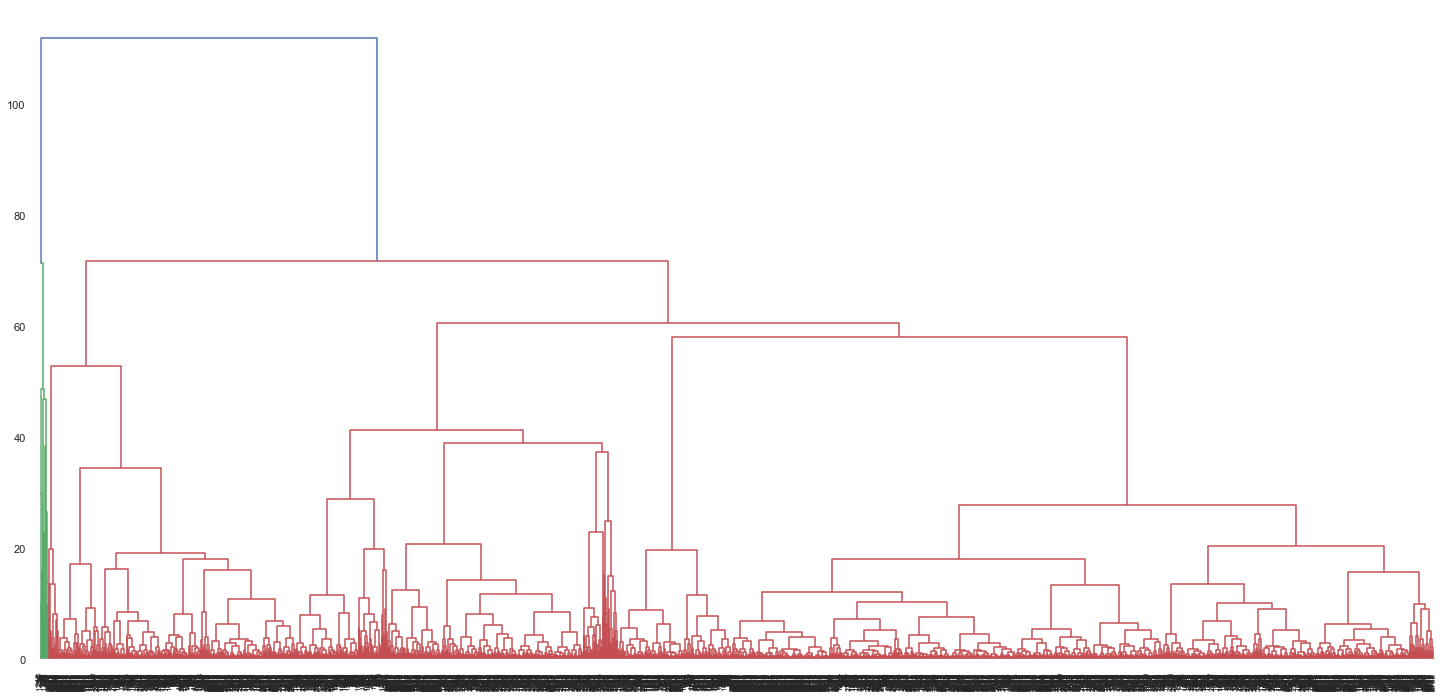

In [69]:
# Visualize dendogram I
# hc.dendrogram(
#     hc_model,
#     leaf_rotation=90,
#     leaf_font_size=8,
# )
# plt.plot()

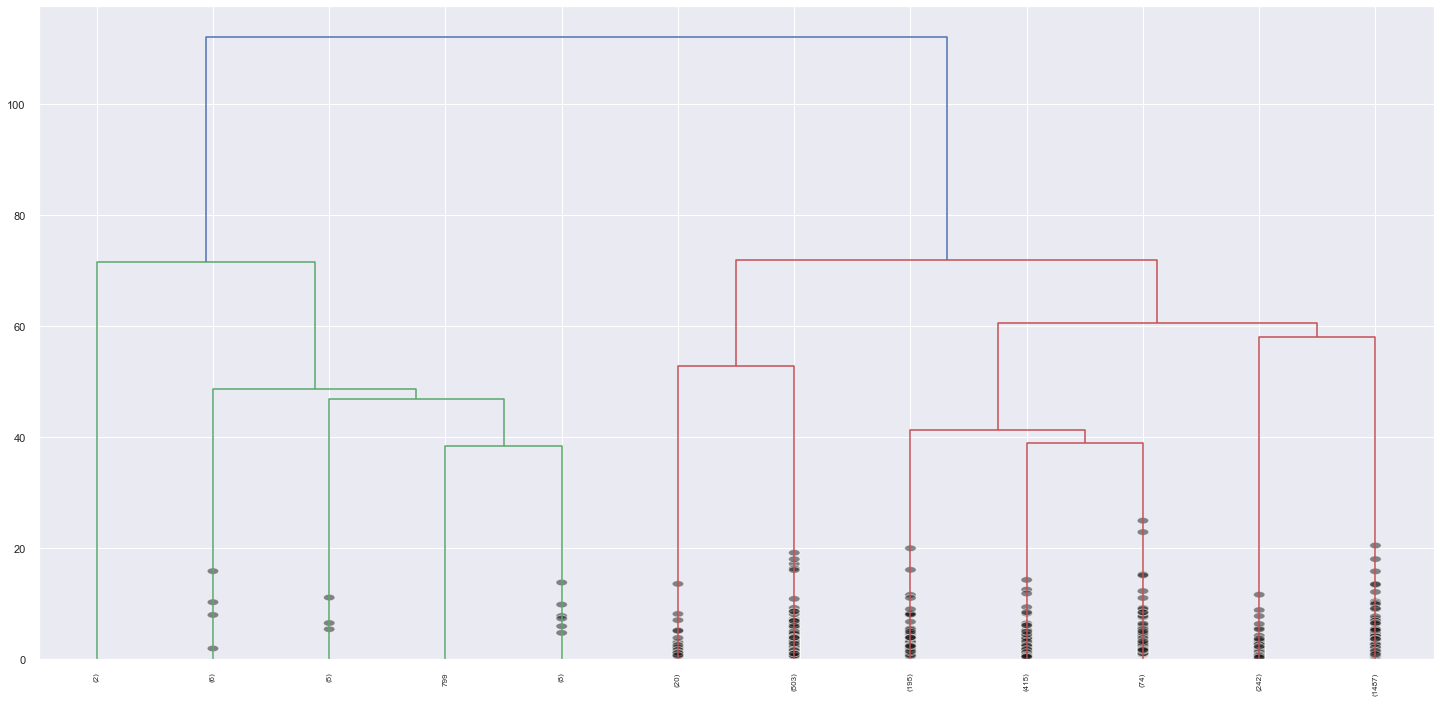

In [70]:
# Visualize dendrogram II
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True,
)
plt.show()

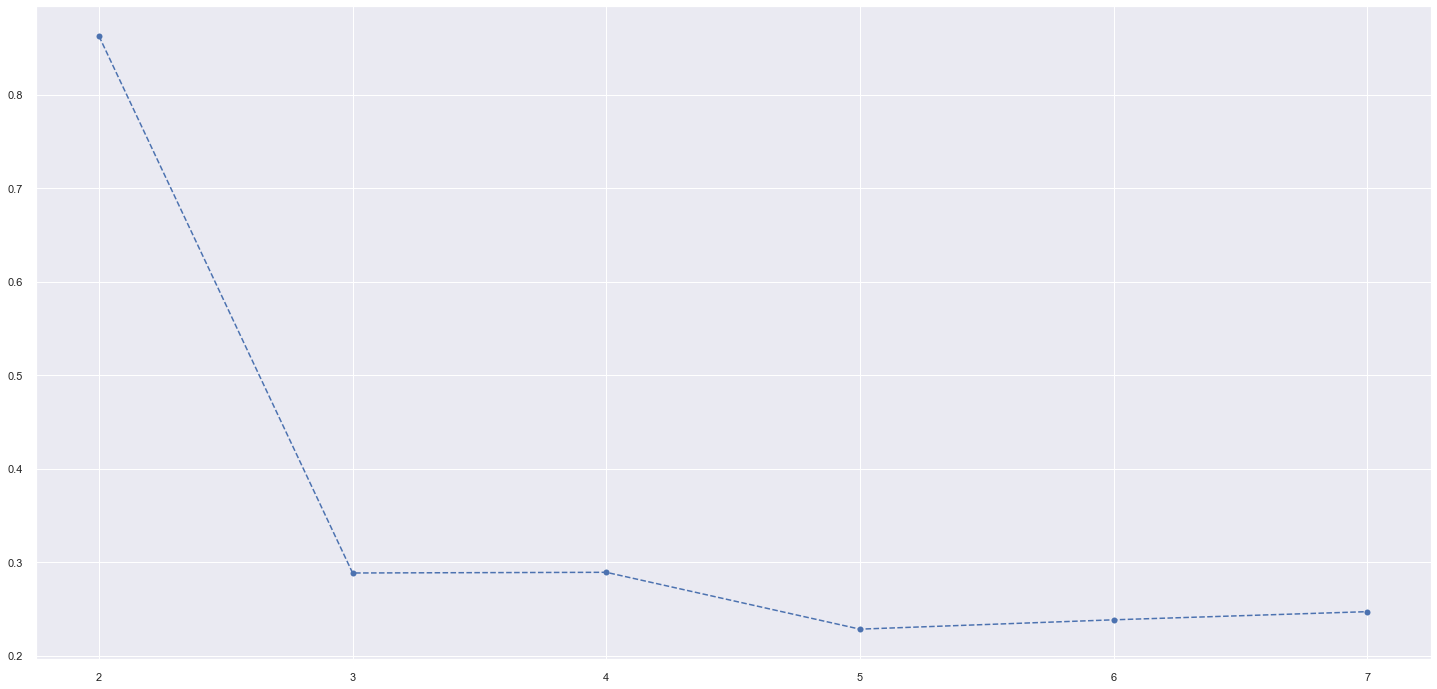

In [75]:
# Silhouette Score
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X,'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)
    
# Plot Silhouette Score
plt.plot(clusters, hc_list, linestyle='--', marker='o',color='b');

## 7.4 DBSCAN

In [76]:
from sklearn.neighbors import NearestNeighbors

In [84]:
min_samples = 20
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

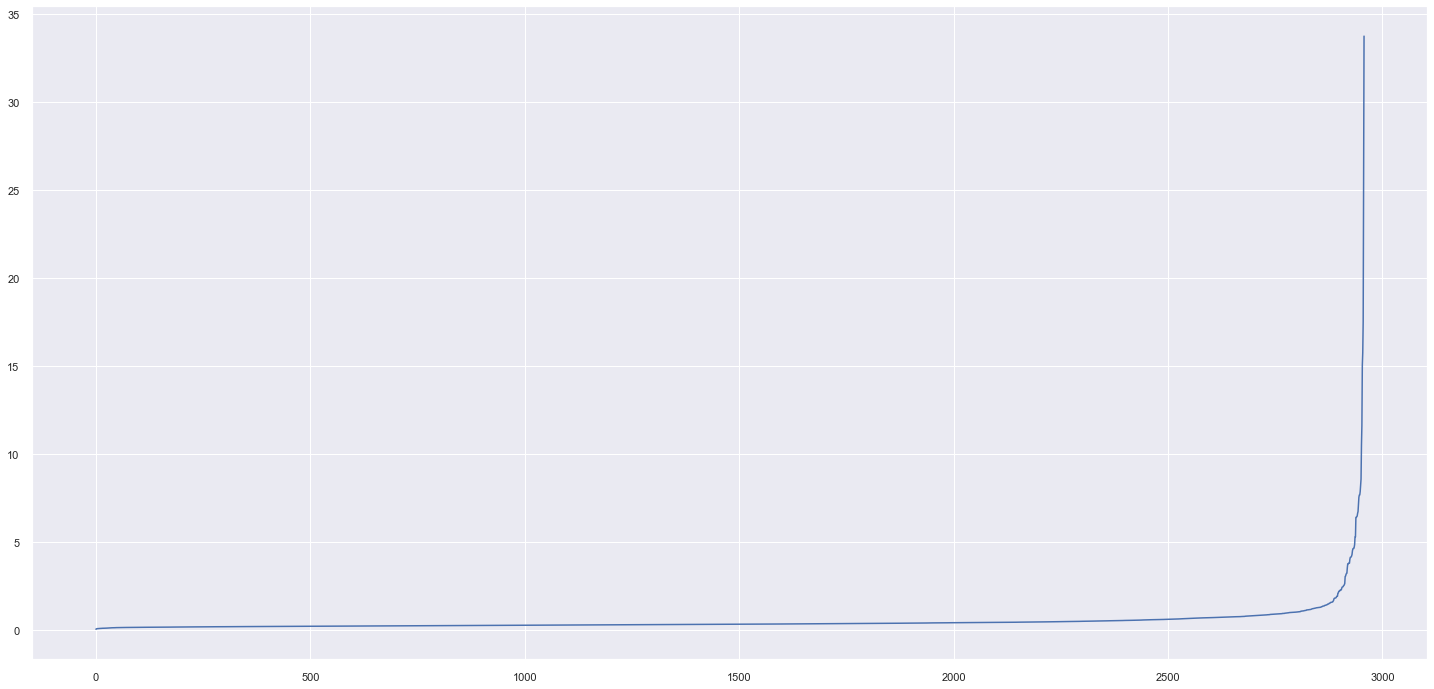

In [85]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

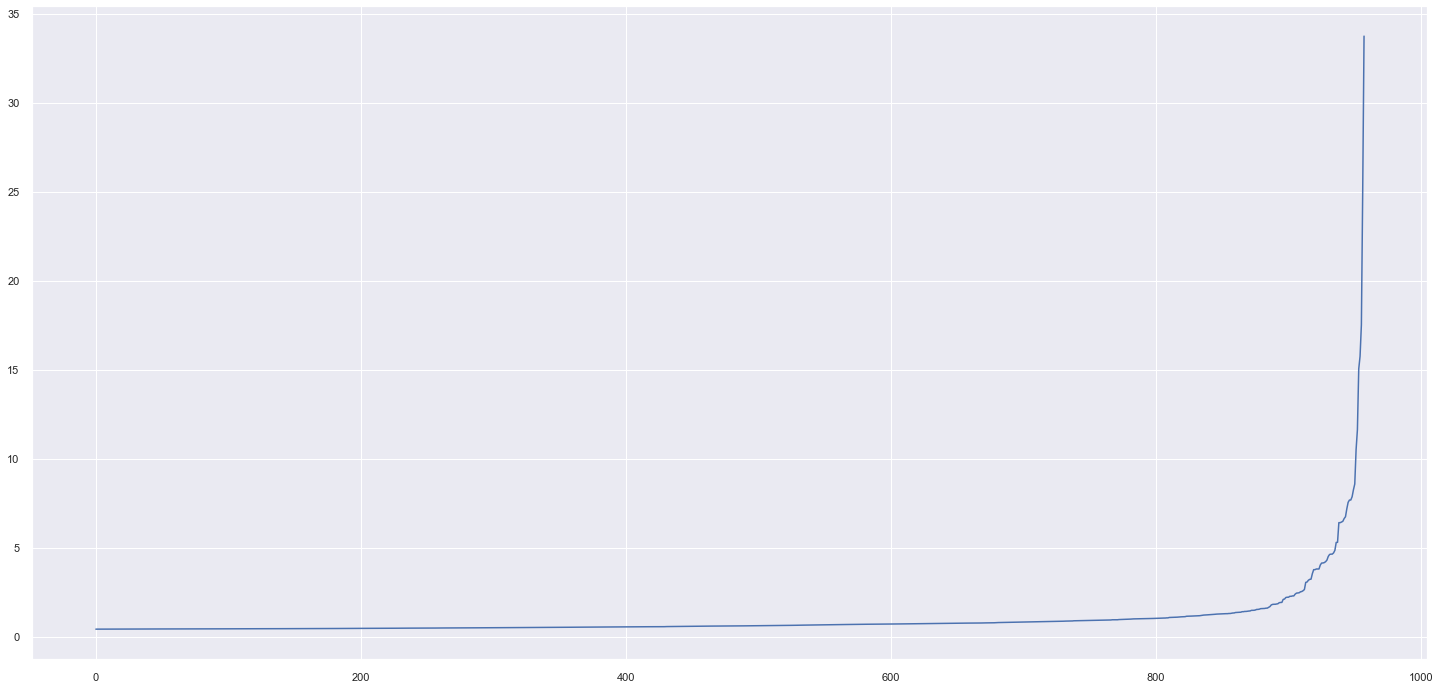

In [81]:
plt.plot( distances[2000:] );

In [91]:
eps = 2

# model definition 
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and prediction
labels = dbscan_model.fit_predict(X)
 
# model performance - Silhouette Score
sil = m.silhouette_score(X, labels, metric= 'euclidean')
print('Silhouette Score:',sil)
print('Number of Clusters: {}'.format(len(unique(labels))))

dbscan_list = [ sil_score, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

Silhouette Score: 0.7295568250416499
Number of Clusters: 2


## 7.5 Results

In [92]:
df_results = pd.DataFrame(
                {'KMeans':kmeans_list,
                'GMM':gmm_list,
                'Hierarquical Clustering': hc_list,
                'DBSCAN': dbscan_list}).T
df_results.columns = clusters

In [93]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7
KMeans,0.867860,0.282096,0.301905,0.298558,0.292620,0.304461
GMM,0.303564,0.086209,0.036954,0.046546,0.013949,0.053851
Hierarquical Clustering,0.862645,0.288329,0.289059,0.228249,0.238238,0.246954
DBSCAN,0.880128,0.000000,0.000000,0.000000,0.000000,0.000000


## 7.6 Silhouette Analysis

For k = 2, Silhouette Score: 0.8626445152470001
For k = 3, Silhouette Score: 0.28832919297988524
For k = 4, Silhouette Score: 0.28905853305775164
For k = 5, Silhouette Score: 0.22824866795231524
For k = 6, Silhouette Score: 0.2382383104392819
For k = 7, Silhouette Score: 0.2469539340999573


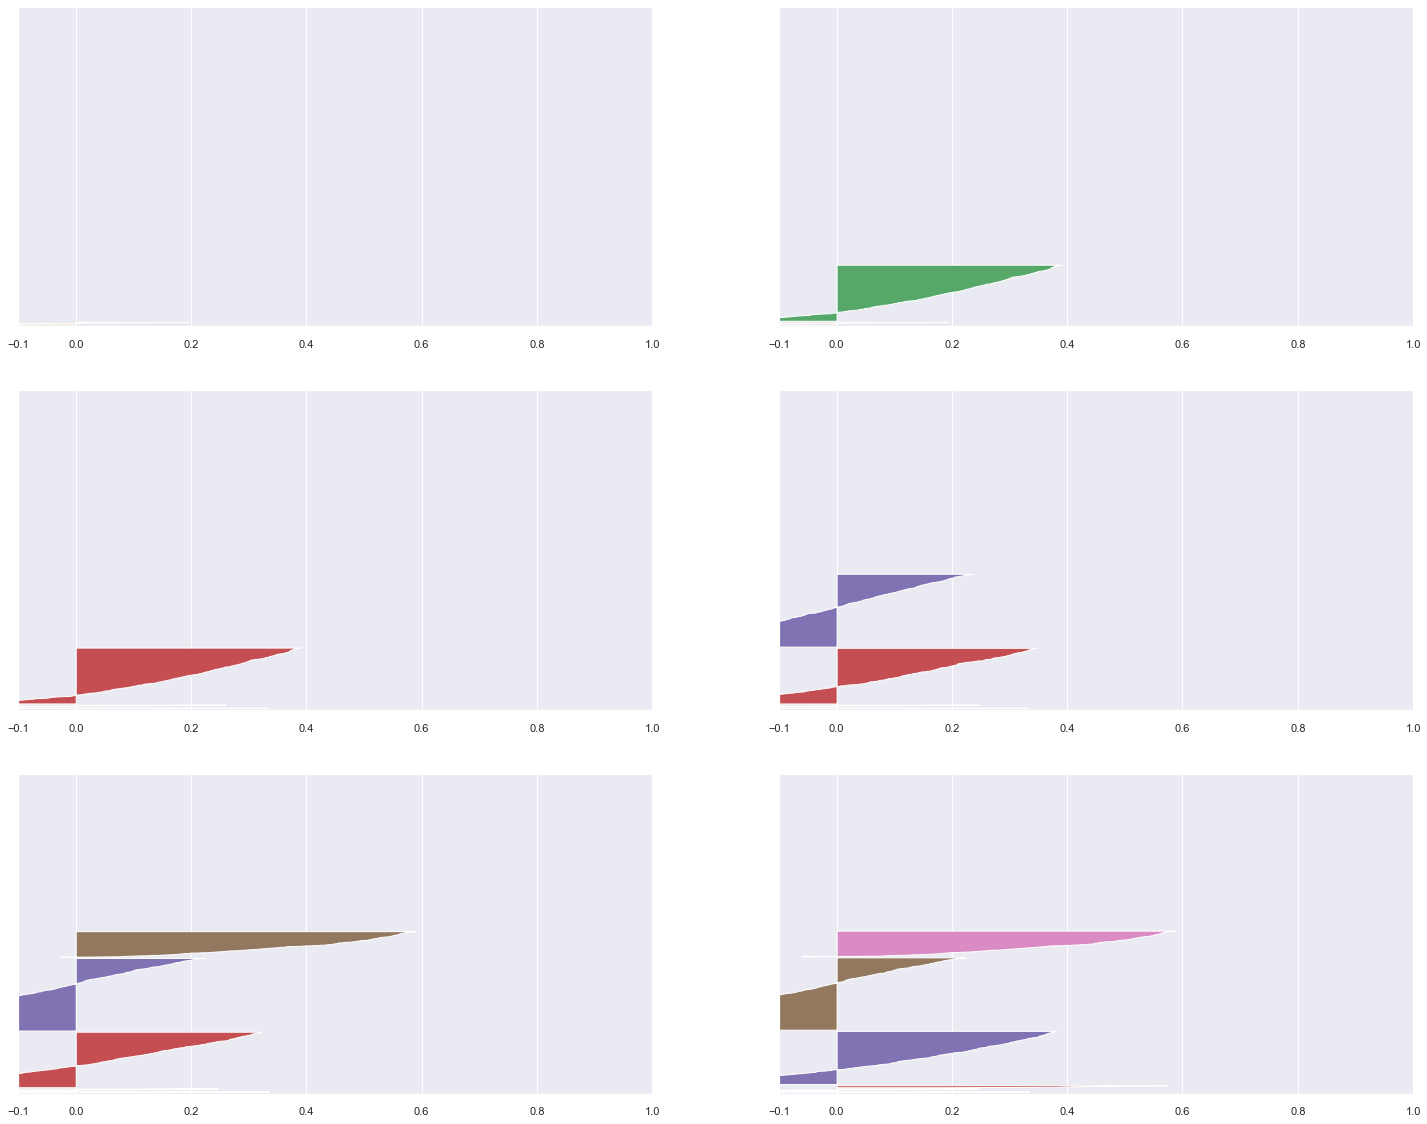

In [96]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
        q, mod = divmod(k,2)
        
        ax[q-1, mod].set_xlim([-0.1,1])
        ax[q-1, mod].set_ylim([0,len(X) + (k-1)*10])
        
        # model definition and training
        hc_model = hc.linkage(X,'ward')
        
        # model prediction
        labels = hc.fcluster(hc_model, k, criterion ='maxclust')
        
        # model performance
        ss = m.silhouette_score(X, labels, metric='euclidean')
        print('For k = {}, Silhouette Score: {}'.format(k,ss ))
        
        samples_silhouette_values = m.silhouette_samples(X, labels )
        
        y_lower = 10
        
        for i in range(k):
            
            # select clusters
            ith_samples_silhouette_values = samples_silhouette_values[labels==i]
            
            # sorte values
            ith_samples_silhouette_values.sort()
            
            #size clusters
            size_cluster_i = ith_samples_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap('Spectral')
            color = cmap(i/k)
            
            ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper),0,ith_samples_silhouette_values)
            
            y_lower= y_upper +10
        ax[q-1, mod].set_yticks([])
        ax[q-1, mod].set_xticks([-0.1,0,0.2, 0.4, 0.6, 0.8, 1])
        

# 8.0 Model Training

Bases on Silhoutte Score, we selected 2 clusters as the optimal number of k.

## 8.1 K-Means

In [ ]:
# Model definition
k = 2
model_train = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model Training
model_train.fit(X)

# Clustering
labels = model_train.labels_

In [ ]:
## Cluster Validation
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( model_train.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

## 8.2 Hierarquical Clustering

In [ ]:
# Model definition
hierarchy = c.AgglomerativeClustering(n_clusters=2, linkage = 'average')

# Model Training
hierarchy.fit(X)

# Model Prediction - Clustering
labels = hierarchy.fit_predict(X)

## Cluster Validation
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

# 9.0 Cluster Analysis

In [ ]:
df9 =df6.copy() 

# Adding the clustes 
df9['cluster'] = labels

df9.head()

In [ ]:
### Ideas for visualization
# Radar graph with clusters

## 9.1 Visualization Inspection

In [ ]:
km = c.KMeans( init='random', n_clusters=2, n_init=10, max_iter=300, random_state=42)
visualizer = SilhouetteVisualizer(km,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d Plot

In [ ]:
df_viz = df9.drop(columns='customer_id',axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP

In [ ]:
reducer = umap.UMAP( n_neighbors=90,random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot view
sns.scatterplot( x='embedding_x', y='embedding_y',
               hue='cluster', data=df_viz, palette=sns.color_palette('hls',n_colors=len(df_viz.cluster.unique())));


## 9.4 Cluster Profile

In [ ]:
### INVERSE TRANSFORM NOT WORKING FOR SOME REASON
# # Undo the data transformation

# df9.gross_revenue = ss.inverse_transform(df5[['gross_revenue']])
# df9.recency_days = ss.inverse_transform(df5[['recency_days']])
# df9.invoice_no = ss.inverse_transform(df5[['invoice_no']])
# df9.avg_ticket = ss.inverse_transform(df5[['avg_ticket']])

In [ ]:
df9 =df4.copy() 

# Adding the clustes 
df9['cluster'] = labels

df9.head()

In [ ]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_rev = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_rev, how='inner',on='cluster')

# Average Recency Days
df_avg_rec_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_rec_days, how='inner',on='cluster')

# Average Number of purchases
df_avg_invoice_no = df9[['number_of_purchases','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner',on='cluster')

# Average Basket Size
df_avg_bs = df9[['avg_basket_size','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_bs, how='inner',on='cluster')

# Average Product Variety
df_avg_pv = df9[['product_variety','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_pv, how='inner',on='cluster')

# Average Ticket 
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner',on='cluster')

# Returns
df_cg = df9[['returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_cg, how='inner',on='cluster')


df_cluster

# 10.0 Deploy